In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split

###Data preparation

In [3]:
data = pd.read_csv("songsDataset.csv",header=0, names=['userID','songID','rating'])
data.shape

(2000000, 3)

<Axes: >

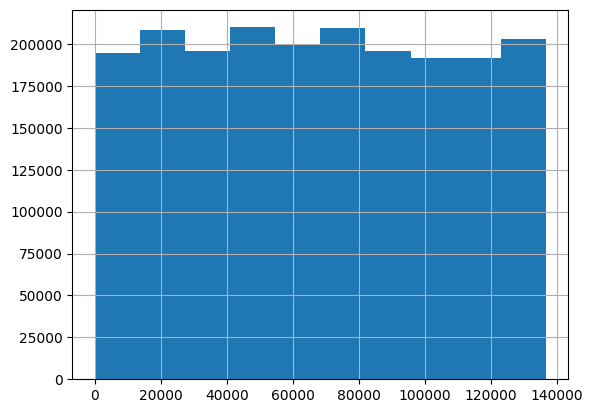

In [4]:
data['songID'].hist()

<Axes: >

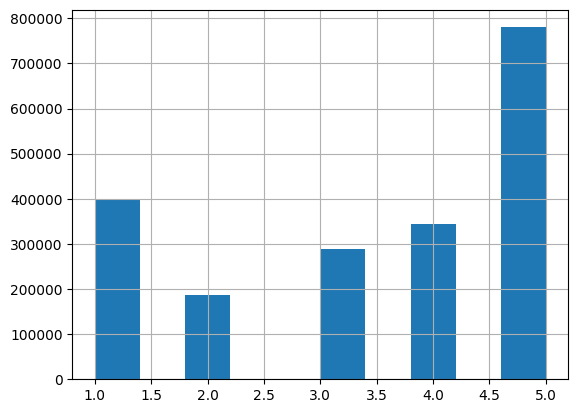

In [5]:
data['rating'].hist()

In [6]:
# Calculate the size of each partition
total_size = len(data)
train_size = total_size * 8 //10  # 80% for training (and make sure the index are integer type not float)
test_size = total_size - train_size  # Remaining 20% for testing
partition_sizes = [train_size // 8] * 8 + [test_size // 2] * 2

# Shuffle the DataFrame rows
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled DataFrame into partitions
partitions = [df_shuffled.iloc[i:i+size] for i, size in enumerate(partition_sizes)]

# Assign partitions to train and test datasets
train_datasets = partitions[:8]
test_datasets = partitions[8:]

In [7]:
N_songs = data['songID'].nunique() # 127771
N_users = data['userID'].nunique() # 200000
N_ratings = data.shape[0] # 2000000
user_ids = list(data['userID'].unique())
song_ids = list(data['songID'].unique())

# Train dataset
combined_array1 = np.concatenate((train_datasets[0],train_datasets[1],train_datasets[2],train_datasets[3],train_datasets[4],train_datasets[5],train_datasets[6],train_datasets[7]),axis=0)
train_df = pd.DataFrame(combined_array1, columns=['userID','songID','rating'])
train_df.reset_index(drop=True, inplace=True) # Optional: Reset index if you want sequential index
len_train_df = train_df.shape[0]

train_users = np.copy(train_df['userID'])
train_songs = np.copy(train_df['songID'])
train_ratings = np.copy(train_df['rating'])

# Test dataset
combined_array2 = np.concatenate((test_datasets[0], test_datasets[1]), axis=0)
test_df = pd.DataFrame(combined_array2, columns=['userID','songID','rating'])
test_df.reset_index(drop=True, inplace=True)

test_users = np.copy(test_df['userID'])
test_songs = np.copy(test_df['songID'])
test_ratings = np.copy(test_df['rating'])

In [8]:
@jax.jit
def loss(U_single,S_single,R_single): # user U, song S, rating R
    prediction = jnp.dot(U_single,S_single)
    error = (R_single-prediction)**2
    return error

loss_grad_U = jax.jit(jax.grad(loss, argnums=0))
loss_grad_S = jax.jit(jax.grad(loss, argnums=1))

def mse(U_batch,S_batch,R_batch):
    predictions = np.sum(U_batch * S_batch,axis=1)
    errors = (R_batch-predictions)**2
    return np.mean(errors)

### 500 iterations, learning rate 0.01

In [ ]:
d_factors = 10
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # 200000 x 10
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors) # 127771 x 10

niter = 500
learning_rate = 0.01
U = U_init.copy()
S = S_init.copy()
MSE = []

In [ ]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(len_train_df)
        user_index = train_users[index] # since user_index and user_id are the same in this dataset
        song_id = train_songs[index]
        song_index = song_ids.index(song_id)
        rating = train_ratings[index]

        U_grad = loss_grad_U(U[user_index],S[song_index],rating)
        S_grad = loss_grad_S(U[user_index],S[song_index],rating)
        U[user_index] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    if ((i+1)%10==0) | (i==0):
        # Compute MSE for the training dataset
        user_indices = [user_ids.index(j) for j in train_users[:10000]]
        U_batch = U[user_indices]
        song_indices = [song_ids.index(k) for k in train_songs[:10000]]
        S_batch = S[song_indices]
        R_batch = train_ratings[:10000]

        mse_train = mse(U_batch,S_batch,R_batch)
        #MSE.append(mse_current)
        #print(f"iter {i+1}, mse={mse_current:.3f}")

        # Compute MSE for the test dataset
        user_indices_test = [user_ids.index(s) for s in test_users[:5000]]
        U_batch_test = U[user_indices_test]
        song_indices_test = [song_ids.index(k) for k in test_songs[:5000]]
        S_batch_test = S[song_indices_test]
        R_batch_test = test_ratings[:5000]

        mse_test = mse(U_batch_test,S_batch_test,R_batch_test)

        MSE.append((mse_train, mse_test))
        print(f"Iteration {i+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 22.71282, Test MSE: 22.82560
Iteration 10, Train MSE: 7.44544, Test MSE: 7.54291
Iteration 20, Train MSE: 3.98000, Test MSE: 3.96155
Iteration 30, Train MSE: 2.57747, Test MSE: 2.56937
Iteration 40, Train MSE: 1.85142, Test MSE: 1.85498
Iteration 50, Train MSE: 1.39489, Test MSE: 1.41819
Iteration 60, Train MSE: 1.11170, Test MSE: 1.14259
Iteration 70, Train MSE: 0.88600, Test MSE: 0.90247
Iteration 80, Train MSE: 0.72679, Test MSE: 0.74801
Iteration 90, Train MSE: 0.59786, Test MSE: 0.62102
Iteration 100, Train MSE: 0.49223, Test MSE: 0.51170
Iteration 110, Train MSE: 0.40423, Test MSE: 0.41975
Iteration 120, Train MSE: 0.33988, Test MSE: 0.35470
Iteration 130, Train MSE: 0.28837, Test MSE: 0.30096
Iteration 140, Train MSE: 0.24139, Test MSE: 0.25229
Iteration 150, Train MSE: 0.20130, Test MSE: 0.20957
Iteration 160, Train MSE: 0.16634, Test MSE: 0.17188
Iteration 170, Train MSE: 0.14175, Test MSE: 0.14796
Iteration 180, Train MSE: 0.12064, Test MSE: 0.12590
It

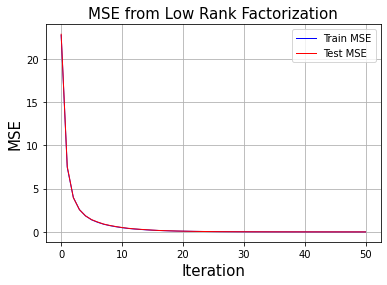

In [ ]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE]
test_mse = [mse_test for _, mse_test in MSE]

plt.plot(train_mse, '-', lw=1, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=1, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

Text(0.5, 0, 'Iteration')

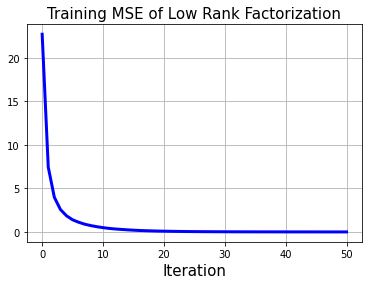

In [ ]:
plt.plot(train_mse,'-',color='blue',lw=3)
plt.grid()
plt.title('Training MSE of Low Rank Factorization',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

In [ ]:
test_song_index = [song_ids.index(song_id) for song_id in test_songs]
# Compute MSE for the combined training dataset
U_batch_test = U[test_users]
S_batch_test = S[test_song_index]
MSE_test = mse(U_batch_test, S_batch_test, test_ratings)
MSE_test

0.0018460382507278711

### 100 iterations, learning rate 0.03

In [ ]:
d_factors = 10
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # 200000 x 10
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors) # 127771 x 10

niter = 100
learning_rate = 0.03
U = U_init.copy()
S = S_init.copy()
MSE = []

In [ ]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(len_train_df)
        user_index = train_users[index] # since user_index and user_id are the same in this dataset
        song_id = train_songs[index]
        song_index = song_ids.index(song_id)
        rating = train_ratings[index]

        U_grad = loss_grad_U(U[user_index],S[song_index],rating)
        S_grad = loss_grad_S(U[user_index],S[song_index],rating)
        U[user_index] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    if ((i+1)%10==0) | (i==0):
        # Compute MSE for the training dataset
        user_indices = [user_ids.index(j) for j in train_users[:10000]]
        U_batch = U[user_indices]
        song_indices = [song_ids.index(k) for k in train_songs[:10000]]
        S_batch = S[song_indices]
        R_batch = train_ratings[:10000]

        mse_train = mse(U_batch,S_batch,R_batch)
        #MSE.append(mse_current)
        #print(f"iter {i+1}, mse={mse_current:.3f}")

        # Compute MSE for the test dataset
        user_indices_test = [user_ids.index(s) for s in test_users[:5000]]
        U_batch_test = U[user_indices_test]
        song_indices_test = [song_ids.index(k) for k in test_songs[:5000]]
        S_batch_test = S[song_indices_test]
        R_batch_test = test_ratings[:5000]

        mse_test = mse(U_batch_test,S_batch_test,R_batch_test)

        MSE.append((mse_train, mse_test))
        print(f"Iteration {i+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 18.04355, Test MSE: 18.12361
Iteration 10, Train MSE: 4.71906, Test MSE: 4.73663
Iteration 20, Train MSE: 2.20874, Test MSE: 2.30892
Iteration 30, Train MSE: 1.25105, Test MSE: 1.31902
Iteration 40, Train MSE: 0.72238, Test MSE: 0.67811
Iteration 50, Train MSE: 0.45982, Test MSE: 0.44754
Iteration 60, Train MSE: 0.28606, Test MSE: 0.27967
Iteration 70, Train MSE: 0.18092, Test MSE: 0.17344
Iteration 80, Train MSE: 0.11597, Test MSE: 0.11444
Iteration 90, Train MSE: 0.08077, Test MSE: 0.07660
Iteration 100, Train MSE: 0.05447, Test MSE: 0.04966


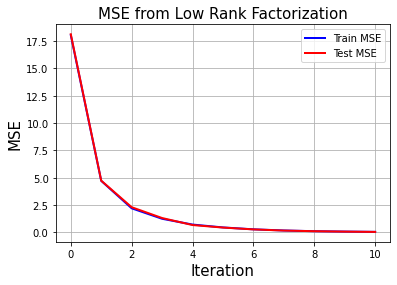

In [ ]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE]
test_mse = [mse_test for _, mse_test in MSE]

# Plot train and test MSE values together
plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

Text(0.5, 0, 'Iteration')

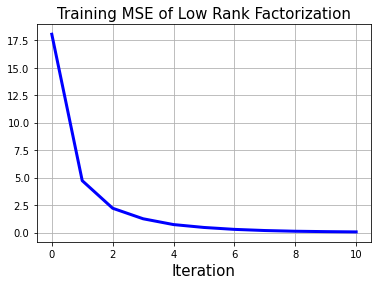

In [ ]:
plt.plot(train_mse,'-',color='blue',lw=3)
plt.grid()
plt.title('Training MSE of Low Rank Factorization',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

### 200 iterations, learning rate 0.03

In [9]:
d_factors = 10
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # 200000 x 10
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors) # 127771 x 10

niter = 200
learning_rate = 0.03
U = U_init.copy()
S = S_init.copy()
MSE = []

In [10]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(len_train_df)
        user_index = train_users[index] # since user_index and user_id are the same in this dataset
        song_id = train_songs[index]
        song_index = song_ids.index(song_id)
        rating = train_ratings[index]

        U_grad = loss_grad_U(U[user_index],S[song_index],rating)
        S_grad = loss_grad_S(U[user_index],S[song_index],rating)
        U[user_index] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    if ((i+1)%10==0) | (i==0):
        # Compute MSE for the training dataset
        user_indices = [user_ids.index(j) for j in train_users[:10000]]
        U_batch = U[user_indices]
        song_indices = [song_ids.index(k) for k in train_songs[:10000]]
        S_batch = S[song_indices]
        R_batch = train_ratings[:10000]

        mse_train = mse(U_batch,S_batch,R_batch)
        #MSE.append(mse_current)
        #print(f"iter {i+1}, mse={mse_current:.3f}")

        # Compute MSE for the test dataset
        user_indices_test = [user_ids.index(s) for s in test_users[:5000]]
        U_batch_test = U[user_indices_test]
        song_indices_test = [song_ids.index(k) for k in test_songs[:5000]]
        S_batch_test = S[song_indices_test]
        R_batch_test = test_ratings[:5000]

        mse_test = mse(U_batch_test,S_batch_test,R_batch_test)

        MSE.append((mse_train, mse_test))
        print(f"Iteration {i+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 18.45860, Test MSE: 18.39863
Iteration 10, Train MSE: 4.71478, Test MSE: 4.71476
Iteration 20, Train MSE: 2.05001, Test MSE: 2.07629
Iteration 30, Train MSE: 1.12915, Test MSE: 1.13315
Iteration 40, Train MSE: 0.68569, Test MSE: 0.69571
Iteration 50, Train MSE: 0.43561, Test MSE: 0.42145
Iteration 60, Train MSE: 0.28555, Test MSE: 0.27350
Iteration 70, Train MSE: 0.18513, Test MSE: 0.16950
Iteration 80, Train MSE: 0.11859, Test MSE: 0.11501
Iteration 90, Train MSE: 0.07721, Test MSE: 0.07521
Iteration 100, Train MSE: 0.05209, Test MSE: 0.05158
Iteration 110, Train MSE: 0.03736, Test MSE: 0.03590
Iteration 120, Train MSE: 0.02485, Test MSE: 0.02471
Iteration 130, Train MSE: 0.01792, Test MSE: 0.01768
Iteration 140, Train MSE: 0.01165, Test MSE: 0.01115
Iteration 150, Train MSE: 0.00821, Test MSE: 0.00787
Iteration 160, Train MSE: 0.00603, Test MSE: 0.00562
Iteration 170, Train MSE: 0.00463, Test MSE: 0.00405
Iteration 180, Train MSE: 0.00355, Test MSE: 0.00321
It

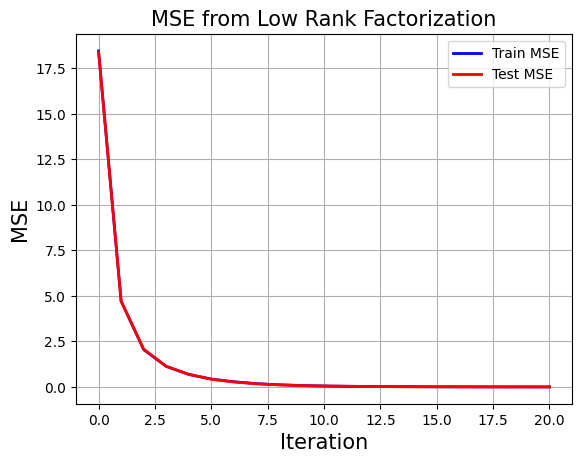

In [11]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE]
test_mse = [mse_test for _, mse_test in MSE]

plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

Text(0.5, 0, 'Iteration')

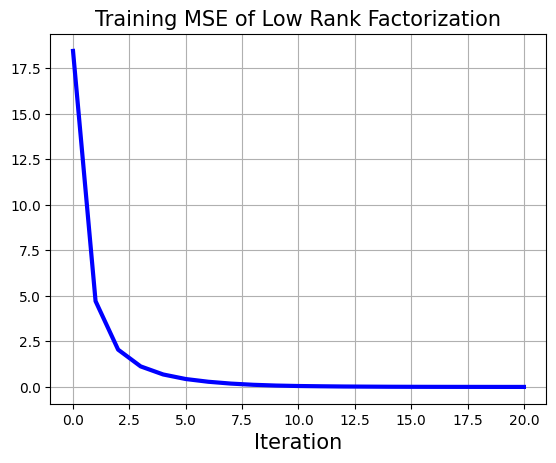

In [12]:
plt.plot(train_mse,'-',color='blue',lw=3)
plt.grid()
plt.title('Training MSE of Low Rank Factorization',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

In [16]:
test_song_index = [song_ids.index(song_id) for song_id in test_songs]
# Compute MSE for the combined training dataset
U_batch_test = U[test_users]
S_batch_test = S[test_song_index]
MSE_test = mse(U_batch_test, S_batch_test, test_ratings)
MSE_test

0.0019071088190531378

### 200 iterations, learning rate 0.05

In [17]:
d_factors = 10
U_init = np.random.normal(3,1,size=(N_users,d_factors))/np.sqrt(d_factors) # 200000 x 10
S_init = np.random.normal(3,1,size=(N_songs,d_factors))/np.sqrt(d_factors) # 127771 x 10

niter = 200
learning_rate = 0.05
U = U_init.copy()
S = S_init.copy()
MSE = []

In [18]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(len_train_df)
        user_index = train_users[index] # since user_index and user_id are the same in this dataset
        song_id = train_songs[index]
        song_index = song_ids.index(song_id)
        rating = train_ratings[index]

        U_grad = loss_grad_U(U[user_index],S[song_index],rating)
        S_grad = loss_grad_S(U[user_index],S[song_index],rating)
        U[user_index] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    if ((i+1)%10==0) | (i==0):
        # Compute MSE for the training dataset
        user_indices = [user_ids.index(j) for j in train_users[:10000]]
        U_batch = U[user_indices]
        song_indices = [song_ids.index(k) for k in train_songs[:10000]]
        S_batch = S[song_indices]
        R_batch = train_ratings[:10000]

        mse_train = mse(U_batch,S_batch,R_batch)
        #MSE.append(mse_current)
        #print(f"iter {i+1}, mse={mse_current:.3f}")

        # Compute MSE for the test dataset
        user_indices_test = [user_ids.index(s) for s in test_users[:5000]]
        U_batch_test = U[user_indices_test]
        song_indices_test = [song_ids.index(k) for k in test_songs[:5000]]
        S_batch_test = S[song_indices_test]
        R_batch_test = test_ratings[:5000]

        mse_test = mse(U_batch_test,S_batch_test,R_batch_test)

        MSE.append((mse_train, mse_test))
        print(f"Iteration {i+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 18.45300, Test MSE: 18.35048
Iteration 10, Train MSE: 5.65522, Test MSE: 5.75058
Iteration 20, Train MSE: 2.69765, Test MSE: 2.66839
Iteration 30, Train MSE: 1.44845, Test MSE: 1.48267
Iteration 40, Train MSE: 0.80364, Test MSE: 0.81567
Iteration 50, Train MSE: 0.45317, Test MSE: 0.47267
Iteration 60, Train MSE: 0.25753, Test MSE: 0.26075
Iteration 70, Train MSE: 0.16114, Test MSE: 0.16268
Iteration 80, Train MSE: 0.09744, Test MSE: 0.09999
Iteration 90, Train MSE: 0.06181, Test MSE: 0.06445
Iteration 100, Train MSE: 0.03946, Test MSE: 0.04032
Iteration 110, Train MSE: 0.02631, Test MSE: 0.02717
Iteration 120, Train MSE: 0.01833, Test MSE: 0.01862
Iteration 130, Train MSE: 0.01324, Test MSE: 0.01301
Iteration 140, Train MSE: 0.00968, Test MSE: 0.01003
Iteration 150, Train MSE: 0.00700, Test MSE: 0.00760
Iteration 160, Train MSE: 0.00494, Test MSE: 0.00536
Iteration 170, Train MSE: 0.00371, Test MSE: 0.00386
Iteration 180, Train MSE: 0.00289, Test MSE: 0.00316
It

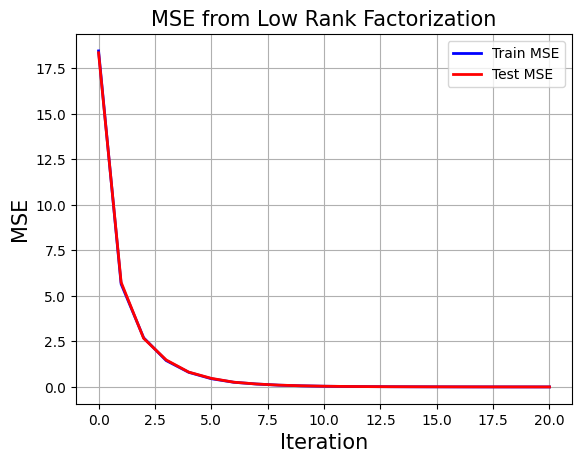

In [19]:
# Separate train and test MSE values
train_mse = [mse_train for mse_train, _ in MSE]
test_mse = [mse_test for _, mse_test in MSE]

plt.plot(train_mse, '-', lw=2, color='blue', label='Train MSE')
plt.plot(test_mse, '-', lw=2, color='red', label='Test MSE')
plt.grid()
plt.title('MSE from Low Rank Factorization', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.legend()
plt.show()

Text(0.5, 0, 'Iteration')

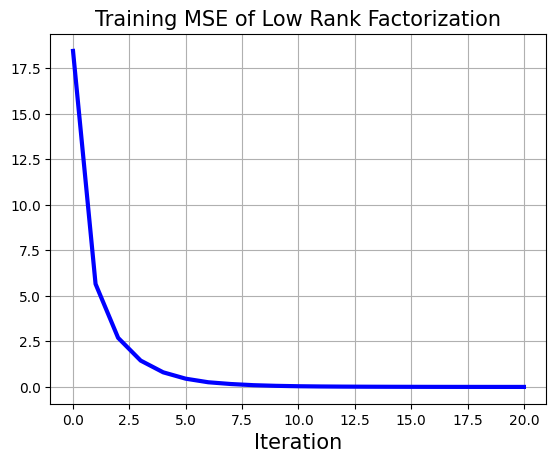

In [20]:
plt.plot(train_mse,'-',color='blue',lw=3)
plt.grid()
plt.title('Training MSE of Low Rank Factorization',fontsize=15)
plt.xlabel('Iteration',fontsize=15)

In [21]:
test_song_index = [song_ids.index(song_id) for song_id in test_songs]
# Compute MSE for the combined training dataset
U_batch_test = U[test_users]
S_batch_test = S[test_song_index]
MSE_test = mse(U_batch_test, S_batch_test, test_ratings)
MSE_test

0.002243892641704232

### 200 iterations, learning rate 0.05, initialization (0,1)

In [ ]:
d_factors = 10
U_init = np.random.normal(0,1,size=(N_users,d_factors))/np.sqrt(d_factors) # 200000 x 10
S_init = np.random.normal(0,1,size=(N_songs,d_factors))/np.sqrt(d_factors) # 127771 x 10

niter = 200
learning_rate = 0.05
U = U_init.copy()
S = S_init.copy()
MSE = []

In [ ]:
# Low Rank Factorization
for i in range(niter):
    for index in range(20000):
        index = np.random.randint(len_train_df)
        user_index = train_users[index] # since user_index and user_id are the same in this dataset
        song_id = train_songs[index]
        song_index = song_ids.index(song_id)
        rating = train_ratings[index]

        U_grad = loss_grad_U(U[user_index],S[song_index],rating)
        S_grad = loss_grad_S(U[user_index],S[song_index],rating)
        U[user_index] -= learning_rate * U_grad
        S[song_index] -= learning_rate * S_grad

    if ((i+1)%10==0) | (i==0):
        # Compute MSE for the training dataset
        user_indices = [user_ids.index(j) for j in train_users[:10000]]
        U_batch = U[user_indices]
        song_indices = [song_ids.index(k) for k in train_songs[:10000]]
        S_batch = S[song_indices]
        R_batch = train_ratings[:10000]

        mse_train = mse(U_batch,S_batch,R_batch)
        #MSE.append(mse_current)
        #print(f"iter {i+1}, mse={mse_current:.3f}")

        # Compute MSE for the test dataset
        user_indices_test = [user_ids.index(s) for s in test_users[:5000]]
        U_batch_test = U[user_indices_test]
        song_indices_test = [song_ids.index(k) for k in test_songs[:5000]]
        S_batch_test = S[song_indices_test]
        R_batch_test = test_ratings[:5000]

        mse_test = mse(U_batch_test,S_batch_test,R_batch_test)

        MSE.append((mse_train, mse_test))
        print(f"Iteration {i+1}, Train MSE: {mse_train:.5f}, Test MSE: {mse_test:.5f}")

Iteration 1, Train MSE: 14.17628, Test MSE: 14.20860
Iteration 10, Train MSE: 8.44703, Test MSE: 8.46001
Iteration 20, Train MSE: 4.18769, Test MSE: 4.13933
Iteration 30, Train MSE: 2.06043, Test MSE: 2.07796
Iteration 40, Train MSE: 0.99680, Test MSE: 0.99340
Iteration 50, Train MSE: 0.47599, Test MSE: 0.48335
Iteration 60, Train MSE: 0.24033, Test MSE: 0.23415
Iteration 70, Train MSE: 0.12586, Test MSE: 0.11171
Iteration 80, Train MSE: 0.06655, Test MSE: 0.06106
Iteration 90, Train MSE: 0.03360, Test MSE: 0.02466
Iteration 100, Train MSE: 0.02099, Test MSE: 0.01429
Iteration 110, Train MSE: 0.00908, Test MSE: 0.00645
Iteration 120, Train MSE: 0.00574, Test MSE: 0.00414
Iteration 130, Train MSE: 0.00334, Test MSE: 0.00268
Iteration 140, Train MSE: 0.00188, Test MSE: 0.00125
Iteration 150, Train MSE: 0.00126, Test MSE: 0.00058
Iteration 160, Train MSE: 0.00101, Test MSE: 0.00039
Iteration 170, Train MSE: 0.00069, Test MSE: 0.00023
Iteration 180, Train MSE: 0.00014, Test MSE: 0.00014
It

In [ ]:
test_song_index = [song_ids.index(song_id) for song_id in test_songs]
# Compute MSE for the combined training dataset
U_batch_test = U[test_users]
S_batch_test = S[test_song_index]
MSE_test = mse(U_batch_test, S_batch_test, test_ratings)
MSE_test

0.00029092999373530964

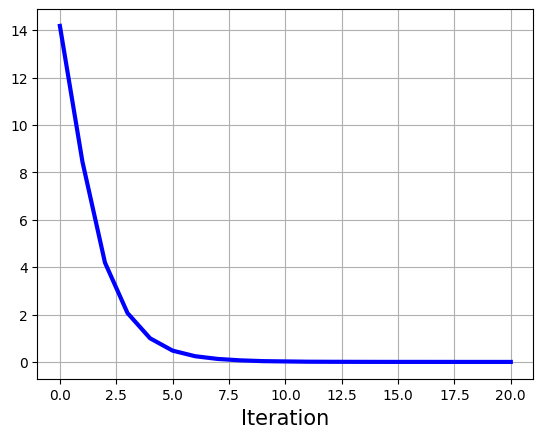

In [ ]:
train_mse = [mse_train for mse_train, _ in MSE]

plt.plot(train_mse,'-',color='blue',lw=3)
plt.grid()
# plt.title('Training MSE of Low Rank Factorization',fontsize=15)
plt.xlabel('Iteration',fontsize=15)
plt.show()